In [1]:
from xclib.data import data_utils
import numpy as np
import time
import pickle

In [2]:
#Change this later. Make the path as command line argument
X_train = data_utils.read_sparse_file('ass3_parta_data/train_x.txt', force_header=True)
train_class = np.genfromtxt('ass3_parta_data/train_y.txt').reshape(-1, 1)

X_valid = data_utils.read_sparse_file('ass3_parta_data/valid_x.txt', force_header=True)
valid_class = np.genfromtxt('ass3_parta_data/valid_y.txt').reshape(-1, 1)

X_test = data_utils.read_sparse_file('ass3_parta_data/test_x.txt', force_header=True)
test_class = np.genfromtxt('ass3_parta_data/test_y.txt').reshape(-1, 1)

/home/ayushi/.local/lib/python3.6/site-packages/xclib-0.96-py3.6-linux-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [3]:
f = open('ass3_parta_data/train_x.txt') 
m,n = f.readlines()[0].rstrip("\n").split(" ")
m,n = int(m),int(n)
f.close()

In [4]:
classes = np.unique(train_class)
pos_class_ind = np.where(train_class == 1)
neg_class_ind = np.where(train_class == 0)

In [5]:
attributes = np.array(range(X_train.A.shape[1]))

### Entropy H(Y) is calculated assuming Y only has two classes - 0 and 1

###### So we use log_2 and use pos and neg_num

In [6]:
def calc_entropyY(train_data, train_class):
    pos_num = train_data[np.where(train_class == 1)[0]].shape[0]
    neg_num = train_data[np.where(train_class == 0)[0]].shape[0]
    
    if (pos_num == 0) or (neg_num == 0):
        entr = 0 #in the limit
    else:
        entr = (pos_num/(pos_num+neg_num))*np.log2((pos_num+neg_num)/pos_num) + (neg_num/(pos_num+neg_num))*np.log2((pos_num+neg_num)/neg_num)
        
    return entr

In [7]:
#Entropy of Raw data
start = time.time()
print(calc_entropyY(X_train.A, train_class))
print("time = ", time.time()-start)

0.997775157550985
time =  0.08955001831054688


#### Reduction in Error is given by H(Y|X) by using value to split at the node
H(Y|X) 

       = H(Y|X=x)P(X=x)  -- find the two splits 

       = H(Y=y|X=x)P(X=x) -- find the entropy of both the splits. 

       = calc_entropy(split1, train_class_split1).P(X=x)
    

In [8]:
def calc_red_error(train_data, split, split_class, train_class):
    #print("In reduction of Error Module")
    #print(train_data.shape[0])
    error = 0
    for i in range(len(split)):
    #    print("Split shape = ", split[i].shape)
        error += (split[i].shape[0]/train_data.shape[0])*calc_entropyY(split[i], split_class[i])
    #print("Reduction in error = ", error)
    return error


In [9]:
def find_best_attr(train_data, train_class):
    #max_mutual_info = 0;   This doesnt work for the cases when mutual info becomes negative. 
    max_mutual_info = float("-inf");
    median = (np.median(train_data, axis=0))        
    #print(median)
    for i in range(len(attributes)):
        split = []
        split_class = []
        split.append(train_data[np.where(train_data[:,i] <= median[i])])
        split.append(train_data[np.where(train_data[:,i] > median[i])])
        split_class.append(train_class[np.where(train_data[:,i] <= median[i])])
        split_class.append(train_class[np.where(train_data[:,i] > median[i])])
        mutual_info = calc_entropyY(train_data, train_class) - calc_red_error(train_data, split, split_class, train_class)
        #print(mutual_info)
        if max_mutual_info < mutual_info:
            max_mutual_info = mutual_info
            best_attr = attributes[i]
            thres = median[i]
    return max_mutual_info, best_attr, thres

In [10]:
start = time.time()
print(find_best_attr(X_train.A, train_class))
print(time.time()-start)

(0.0793751756882577, 217, 0.0)
38.57089018821716


### Every Node  in the tree will have the following contents:

1. Left Subtree
2. Right Subtree
3. Attribute Name on which this node will split
4. Threshold of the attribute for left and right subtree (Median) - int value
5. Entropy
6. Whether this node is leaf or not - True/False
7. A final value of Y=0 or Y=1 in case of leaf

In [11]:
class newNode(object):
    def __init__(self, attr, Th, value):
        self.left = None
        self.right = None
        self.attribute = attr
        self.threshold = Th
        self.value = value
        self.leaf = False
        self.final = None
        self.parent = None
    
    def find_root(self):
        while (self.parent is not None):
            self = self.parent
            self = self.find_root()
        root = self
        return root

    def calc_accuracy(self, tra_data, tra_classes, val_data, val_classes, test_data, test_classes):
        root = self.find_root()
        #print("Root found at = ", root)
        t_acc = 0; v_acc = 0; tes_acc = 0
        for i in range(len(tra_data)):
            pred = predict(root, tra_data[i])
            if (pred == tra_classes[i]):
                t_acc+=1
        for i in range(len(val_data)):
            pred = predict(root, val_data[i])
            if (pred == val_classes[i]):
                v_acc += 1
        for i in range(len(test_data)):
            pred = predict(root, test_data[i])
            if(pred == test_classes[i]):
                tes_acc+=1
        
        return t_acc/len(tra_classes), v_acc/len(val_classes), tes_acc/len(test_classes);

In [12]:
class Tree(object):
    def __init__(self):
        self.tree = None
    def buildTree(self, data, classes, parent, depth, d_thres):
        self.tree = growTree(data, classes, parent, depth, d_thres)

In [13]:
def predict(tree, data):
    if tree.leaf:
        return tree.final
    if tree.left is None and tree.right is None:
        if tree.value[0] > tree.value[1]:
            return 0
        else:
            return 1
    if data[tree.attribute] <= tree.threshold:
        return predict(tree.left, data)
    elif data[tree.attribute] > tree.threshold:
        return predict(tree.right, data)


In [14]:
def growTree(train_data, classes, parent, depth, depth_threshold):
    global num_nodes
    pos_num = train_data[np.where(classes == 1)[0]].shape[0]
    neg_num = train_data[np.where(classes == 0)[0]].shape[0]
    #print("The number of nodes present in the graph = ", num_nodes)
    #print(neg_num, pos_num)

    if (depth == depth_threshold):
        num_nodes+=1
        leaf = newNode(None, None, None)
        leaf.parent = parent
        leaf.leaf = True
        if (pos_num > neg_num):
            leaf.final = 1
        else:
            leaf.final = 0
        return leaf
            
    elif(pos_num == 0 or neg_num == 0):
        num_nodes+=1
        leaf = newNode(None, None, None)
        leaf.leaf = True
        leaf.parent = parent
        
        if(pos_num != 0):
            leaf.final = 1
        elif(neg_num != 0):
            leaf.final = 0
        return leaf
        
    else:
        mutual_info, best_attr, thresh = find_best_attr(train_data, classes)
        #print("Best Attribute with Threshold = ", best_attr, thresh)
        num_nodes+=1
        left_split = train_data[np.where(train_data[:,best_attr] <= thresh)]
        right_split = train_data[np.where(train_data[:,best_attr] > thresh)]
        left_split_class = classes[np.where(train_data[:,best_attr] <= thresh)]
        right_split_class = classes[np.where(train_data[:,best_attr] > thresh)]
        
        if (left_split.shape[0] == 0):
            leaf = newNode(None, None, None)
            leaf.parent = parent
            
            leaf.leaf = True
            pos = left_split[np.where(left_split_class == 1)[0]].shape[0]
            neg = left_split[np.where(left_split_class == 0)[0]].shape[0]
            if (pos>neg):
                leaf.final = 1
            else:
                leaf.final = 0
            return leaf
        elif (right_split.shape[0] == 0):
            leaf = newNode(None, None, None)
            leaf.leaf = True
            leaf.parent = parent
            
            pos = right_split[np.where(right_split_class == 1)[0]].shape[0]
            neg = right_split[np.where(right_split_class == 0)[0]].shape[0]
            if (pos>neg):
                leaf.final = 1
            else:
                leaf.final = 0
            return leaf
        else:
            addNode = newNode(best_attr, thresh, [neg_num, pos_num])
            addNode.parent = parent
            #print(parent)
            #print("The value of the class examples in this node = ", addNode.value)
            #print("Building left tree on =", left_split.shape[0])
            addNode.left = growTree(left_split, left_split_class, addNode, depth+1, depth_threshold)
            #print("Building right tree in = ", right_split.shape[0])
            addNode.right = growTree(right_split, right_split_class, addNode, depth+1, depth_threshold)
            return addNode

In [30]:
nodes = []
time_taken = []
train_acc=[]; val_acc= []; test_acc = []

depth = [5, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25]

for d in depth:
    start = time.time()
    num_nodes = 0
    root = Tree()
    root.buildTree(X_train.A, train_class, None, 0, d)
    time_taken.append(time.time() - start)
    nodes.append(num_nodes)
    trainA, valA, testA = root.tree.calc_accuracy(X_train.A, train_class, X_valid.A, valid_class, X_test.A, test_class)
    train_acc.append(trainA)
    val_acc.append(valA)
    test_acc.append(testA)
    print(num_nodes, train_acc[-1], val_acc[-1], test_acc[-1])
    
#root = growTree(X_train.A, train_class, 0, 8)
#print("Time Taken to grow tree = ", time.time() - start)

61 0.6846846846846847 0.6785184498423883 0.6841592879328728
781 0.7596155332004388 0.7447617281661413 0.7513791664735061
1159 0.7661057283698793 0.7468941220100129 0.7519818274535256
1625 0.7874461082008252 0.7646486185796403 0.7723332251634139
2187 0.7964705700554757 0.7688206934915631 0.7749756617681146
2847 0.8046605782454839 0.773178193955127 0.7785452691113068
3623 0.7990511952776104 0.7608937511589097 0.7663529739001437
4449 0.805371409144994 0.7629334322269609 0.7647767836447081
5355 0.8061285985814288 0.7577878731689227 0.7614389689861388
6353 0.8119852270795667 0.7567216762469868 0.7612071763015159
7427 0.8157711742617403 0.7581587242722048 0.7591674006768346
8597 0.8142258896975878 0.7505562766549231 0.7550414908905475
14591 0.8375133280793658 0.7426756907101799 0.7458161420425571


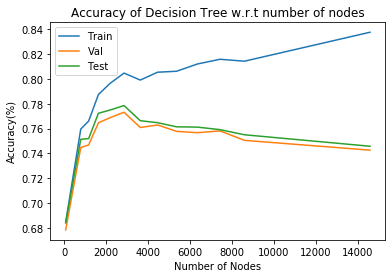

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(nodes, train_acc, label='Train')
plt.plot(nodes, val_acc, label='Val')
plt.plot(nodes, test_acc, label='Test')
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracy(%)")
plt.title("Accuracy of Decision Tree w.r.t number of nodes")
#plt.plot(nodes, depth)
plt.legend()
plt.savefig("depth_accuracy1.png", dpi=1000, bbox_inches='tight')